# Cart-Pole with Walls, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController, FeasibleSetLibrary
from pympc.geometry.polytope import Polytope

numeric parameters

In [3]:
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
t_s = .05

dynamics

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.0 (contact with left wall)
A_0 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B_0 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_0 = np.array([
    [0.],
    [0.],
    [0.],
    [(d*k)/(l*mp)]
    ])
S_0 = ds.DTAffineSystem.from_continuous(A_0, B_0, c_0, t_s, method)

# dynamics n.1 (free)
A_1 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [0., g*(mc+mp)/(l*mc), 0., 0.]
    ])
B_1 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_1 = np.zeros((4,1))
S_1 = ds.DTAffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2 (contact with right wall)
A_2 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B_2 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_2 = np.array([
    [0.],
    [0.],
    [0.],
    [-(d*k)/(l*mp)]
    ])
S_2 = ds.DTAffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_0, S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state bounds
x_max = np.array([[1.5*d],[np.pi/8.],[4.],[2.]])
x_min = -x_max

# state domain n.1
lhs_0 = np.array([[1., -l, 0., 0.]])
rhs_0 = np.array([[-d]])
X_0 = Polytope.from_bounds(x_min, x_max)
X_0.add_facets(lhs_0, rhs_0)
X_0.assemble()

# state domain n.2
lhs_1 = np.array([[-1., l, 0., 0.], [1., -l, 0., 0.]])
rhs_1 = np.array([[d], [d]])
X_1 = Polytope.from_bounds(x_min, x_max)
X_1.add_facets(lhs_1, rhs_1)
X_1.assemble()

# state domain n.3
lhs_2 = np.array([[-1., l, 0., 0.]])
rhs_2 = np.array([[-d]])
X_2 = Polytope.from_bounds(x_min, x_max)
X_2.add_facets(lhs_2, rhs_2)
X_2.assemble()

# list of state domains
X = [X_0, X_1, X_2]

# input domain
u_max = np.array([[15.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*3

We can now define the PWA system.

In [6]:
pwa_sys = ds.DTPWASystem.from_orthogonal_domains(S, X, U)

In [7]:
# controller parameters
N = 15
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[1].A, S[1].B, Q, R)
#X_N = ds.moas_closed_loop(S[1].A, S[1].B, K, X[1], U[1])

# save
#np.save('moas_cart_pole', X_N)

# load
X_N = np.load('moas_cart_pole.npy').item()

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[.5],[0.],[1.5],[0.]])
u = []
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
terminal_mode = 1
miqp_times = []
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    tic = time.clock()
    u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    miqp_times.append(time.clock() - tic)
    x_next = pwa_sys.simulate(x[k], [u_k[0]])[0][1]
    u.append(u_k[0])
    x.append(x_next)
    u_ws = u_k[1:] + [K.dot(x_k[-1])]
    x_ws = x_k[1:] + [pwa_sys.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (terminal_mode,)

We can use the plot functions to visualize the time evolution of the system.

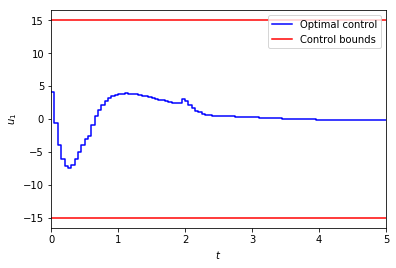

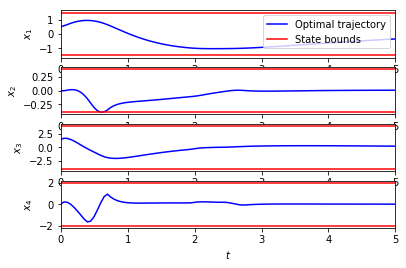

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min, x_max))
plt.show()

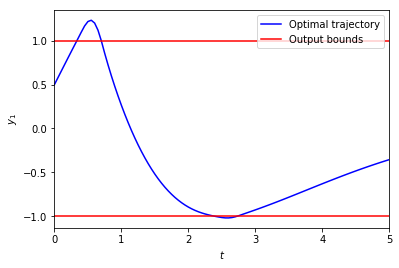

In [10]:
C = np.array([[1., -l, 0., 0.]])
y_max = np.array([[d]])
y_min = -y_max
mpc_plt.output_trajectory(C, x, t_s, (y_min, y_max))
plt.show()

In [11]:
# initialization of the library
#library = FeasibleSetLibrary(controller)

# coverage
#n_samples = 10**4
#library.sample_policy(n_samples)

# shifted switching sequences
#library.add_shifted_switching_sequences(terminal_mode)

# save
#np.save('library_cart_pole_10k', library)

# load
library = np.load('library_cart_pole_10k.npy').item()

In [12]:
import time
# simulate closed loop
#x_0 = np.array([[0.],[0.],[.1],[0.]])

u = []
x = [x_0]
ss = []
ss_feasible = None
library_times = []
for k in range(N_sim):
    tic = time.clock()
    u_k, ss_k = library.feedback(x[k], ss_feasible)
    library_times.append(time.clock() - tic)
    u.append(u_k)
    x.append(pwa_sys.simulate(x[k], [u_k])[0][1])
    ss.append(ss_k)
    ss_feasible = ss_k[1:] + (terminal_mode,)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

In [13]:
print 'library times (min, max, mean):', min(library_times), max(library_times), np.mean(library_times)
print 'miqp times (min, max, mean):', min(miqp_times), max(miqp_times), np.mean(miqp_times)

library times (min, max, mean): 0.031617 0.172806 0.07527106
miqp times (min, max, mean): 0.19781 1.086939 0.40251404


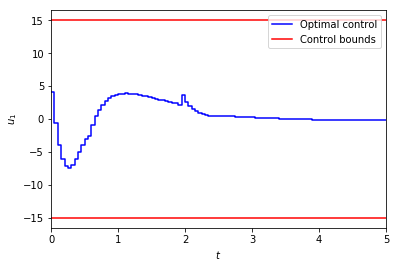

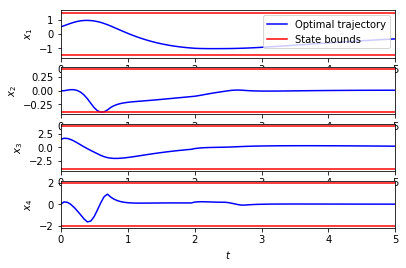

In [14]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min, x_max))
plt.show()

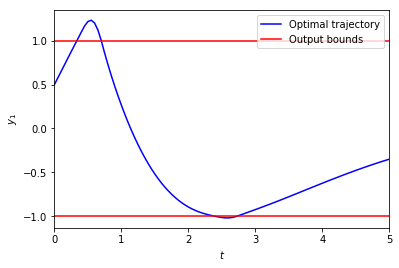

In [15]:
mpc_plt.output_trajectory(C, x, t_s, (y_min, y_max))
plt.show()

## Animate Results with Director

In [16]:
import director.viewerclient as vc
from director.thirdparty import transformations
import time

In [17]:
# contruct a visualizer object
vis = vc.Visualizer()

In [18]:
# construct the environment
vis["wall_left"].setgeometry(vc.GeometryData(vc.Box(lengths=[1.*l, .02*l, 1.*l]),
                                        color=np.hstack((np.array([0.,1.,0.]), 1.))))
vis["wall_left"].settransform(transformations.translation_matrix([0., -d, l]))
vis["wall_right"].setgeometry(vc.GeometryData(vc.Box(lengths=[1.*l, .02*l, 1.*l]),
                                        color=np.hstack((np.array([0.,1.,0.]), 1.))))
vis["wall_right"].settransform(transformations.translation_matrix([0., d, l]))

In [19]:
# cart
vis["cart"].setgeometry(vc.GeometryData(vc.Box(lengths=[.3*l, .3*l, .3*l]),
                                        color=np.hstack((np.array([0.,0.,1.]), 1.))))
# pole
vis["cart"]["pole"].setgeometry(vc.GeometryData(vc.Box(lengths=[.02*l, .05*l, 1.*l]),
                                        color=np.hstack((np.array([1.,0.,0.]), 1.))))
vis["cart"]["pole"].settransform(transformations.translation_matrix([0., 0., .65*l]))

In [20]:
# visualization function
def visualize_cart_pole(x):
    vis["cart"].settransform(transformations.translation_matrix([0., x[0,0], 0.]))
    vis["cart"]["pole"].settransform(
    transformations.rotation_matrix(x[1,0], np.array([1.,0.,0.])).dot(
    transformations.translation_matrix([0., 0., .65*l])
    )
    )

In [22]:
# animation
for k in range(N_sim):
    visualize_cart_pole(x[k])
    time.sleep(t_s)